In [2]:
# https://towardsdatascience.com/how-to-use-the-staple-algorithm-to-combine-multiple-image-segmentations-ce91ebeb451e
# packages
import nibabel as nib # https://nipy.org/nibabel/
import SimpleITK as sitk # https://simpleitk.org/
from matplotlib import pyplot as plt
import os
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="*"))
from collections import OrderedDict
from mdl_seg_class.metrics import dice3d
import torch
import numpy as np
from tqdm.notebook import trange, tqdm


### Recommended gpus on this machine (descending order) ###
  ID  Card name                     Util    Mem free  Cuda             User(s)
----  --------------------------  ------  ----------  ---------------  ---------
   1  NVIDIA GeForce RTX 2080 Ti     0 %   11018 MiB  11.5(495.29.05)
   2  NVIDIA GeForce RTX 2080 Ti     0 %   11018 MiB  11.5(495.29.05)
   3  NVIDIA GeForce RTX 2080 Ti     0 %   11018 MiB  11.5(495.29.05)
   0  NVIDIA GeForce RTX 2080 Ti     0 %    2575 MiB  11.5(495.29.05)  schneider

Will apply following mapping

  ID  Card name                       torch
----  --------------------------  --  -------
   1  NVIDIA GeForce RTX 2080 Ti  ->  cuda:0


In [ ]:
DATA_PATH = "/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/20220114_crossmoda_multiple_registrations/crossmoda_deeds_registered.pth"
bare_data = torch.load(DATA_PATH)

## Calc STAPLE scores

In [ ]:
reg_state = "acummulate_deeds_FT2_MT1"

staple_filter = sitk.STAPLEImageFilter()
# sitk.ProcessObject.SetGlobalDefaultDebugOff()
FOREGROUND = 1.0
weight_data = {}
EVERY = 1
staple_filter.SetForegroundValue(FOREGROUND)
DEBUG = False
if reg_state == "acummulate_deeds_FT2_MT1":
    for fixed_id, moving_dict in bare_data.items():
        # if fixed_id != '111l': continue
        print(fixed_id)
        # print(moving_dict)
        sorted_moving_dict = OrderedDict(moving_dict)
        moving_data = []
        selected_moving_ids = []
        
        for idx_mov, (moving_id, moving_sample) in enumerate(sorted_moving_dict.items()):
            # Only use every third warped sample
            print(idx_mov)
            # idx_mov = 29
            if idx_mov % EVERY == 0:
                moving_data.append(moving_sample['warped_label'][slice_idx].cpu())
                moving_slice_id = f"{fixed_id}:m{moving_id}"
                selected_moving_ids.append(moving_slice_id)

        sitk_moving_data = [sitk.GetImageFromArray(reg_seg.to_dense().numpy().astype(np.int16)) for reg_seg in moving_data]
        _ = staple_filter.Execute(sitk_moving_data)
        # del staple_filter
        # del sitk_moving_data
        # staple_out = sitk.STAPLE(sitk_moving_data, FOREGROUND)
        # consensus = sitk.GetArrayFromImage(staple_out)
        
        # specitivity = staple_filter.GetSpecificity()
        # sensitivity = staple_filter.GetSensitivity()
        # specitivity = sensitivity = [0]*60
        # f_weight_dict = weight_data.get(fixed_id, {})
        # staple_consensus = sitk.GetArrayFromImage(staple_out)
        # for moving_id, sens, spec in zip(selected_moving_ids, sensitivity, specitivity):
        #     weight_data[moving_id] = dict(sensitivity=sens, specitivity=spec)
        # weight_data[fixed_id] = f_weight_dict
    
    if DEBUG: break
else:
    raise ValueError()

torch.save(weight_data, f"./data/staple_calc/{reg_state}_every_{EVERY}_3d_volumes.pth")


In [ ]:
dps = []
for key in weight_data.keys():
    if key == 'data_path': continue
    if np.isnan(weight_data[key]['sensitivity']):
        pass
    else:
        dps.append(weight_data[key]['sensitivity'])
plt.hist(dps)

## Store STAPLE single rater scores (data from mattias)

In [ ]:
from glob import glob
import re

staple_weights = None
staple_description_files = glob("/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_*_L_staple*.txt")

target_t2_keys_w_tumour = ['108r', '111l', '112r', '115l', '118r', '120r', '117l', '123r', '127r', '125l', '134r', '135r', '126l', '142r', '144r', '133l', '148r', '154r', '136l', '160r', '165r', '140l', '166r', '167r', '141l', '168r', '171r', '143l', '173r', '174r', '145l', '179r', '146l', '180r', '181r', '185r', '147l', '195r', '149l', '198r', '204r', '152l', '205r', '209r', '158l', '210r', '162l', '164l', '175l', '177l', '178l', '183l', '187l', '188l', '189l', '190l', '192l', '199l', '200l', '202l']
source_t1_keys_w_tumour = ['100r', '101r', '102l', '103l', '104l', '105l', '010l', '011r', '012r', '013l', '014l', '015l', '016r', '017r', '018l', '019r', '001r', '020l', '021l', '022l', '023r', '024r', '025r', '026l', '027r', '028l', '029r', '002l', '030r', '031l', '032r', '033r', '034l', '035r', '036r', '037r', '038l', '039r', '003r', '040r', '041l', '042l', '042r', '043l', '044r', '045r', '046r', '047r', '048r', '049l', '004r', '050r', '051l', '052r', '053r', '054r', '055l', '056l', '057r', '058l', '059r', '005r', '060r', '061l', '062l', '063l', '064l', '065r', '066l', '067l', '068r', '069l', '006r', '070r', '071l', '072r', '073r', '074r', '075l', '076r', '077r', '078r', '079l', '007r', '080r', '081l', '082r', '083r', '084r', '085r', '086r', '087l', '088l', '089l', '008l', '090l', '091r', '092r', '093l', '094r', '095r', '096r', '097r', '098r', '099l', '099r', '009r']

def get_num_lr_id(num_str):
    num_str = int(num_str)
    if f"{num_str:03d}r" in source_t1_keys_w_tumour:
        _id_str = f"{num_str:03d}r"
    elif f"{num_str:03d}l" in source_t1_keys_w_tumour:
        _id_str = f"{num_str:03d}l"
    elif f"{num_str:03d}r" in target_t2_keys_w_tumour:
        _id_str = f"{num_str:03d}r"
    elif f"{num_str:03d}l" in target_t2_keys_w_tumour:
        _id_str = f"{num_str:03d}l"
    return _id_str

def get_rater_dict(fixed_id, moving_id, rater_id):
    fixed_id_dict = consensus_description_dict.get(fixed_id, {}) 
    moving_id_dict = fixed_id_dict.get(moving_id, {})
    rater_dict = moving_id_dict.get(f"rater_{int(rater_id):03d}", {})
    return rater_dict

def set_rater_dict(consensus_description_dict, rater_dict, fixed_id, moving_id, rater_id):
    fixed_id_dict = consensus_description_dict.get(fixed_id, {})
    fixed_id_dict[moving_id] = rater_dict
    consensus_description_dict[fixed_id] = fixed_id_dict

consensus_description_dict = {}

for _file in staple_description_files:
    for staple_split in ['01','23','45','689']:
        result = re.findall(rf'/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_(\w+)_L_staple{staple_split}\.txt', _file)
        if not result: 
            continue
        else:
            intra_file_dict = {}
            with open(_file, 'r') as description:
                for line in description:
                    # print(line)
                    seg_info = re.findall(rf'Reading #([0-9]+) from (Fcrossmoda_(\w+)_L_M(\w+)_deformed_seg\.nii\.gz)', line)
                    if seg_info:
                        rater_id, seg_path, fixed_id, moving_id = seg_info[0]
                        fixed_id, moving_id = get_num_lr_id(fixed_id), get_num_lr_id(moving_id)
                        # print(fixed_id, moving_id)
                        rater_dict = get_rater_dict(fixed_id, moving_id, rater_id)
                        rater_dict['file'] = seg_path
                        rater_dict['fixed_id'] = fixed_id
                        rater_dict['moving_id'] = moving_id
                        intra_file_dict[int(rater_id)-1] = rater_dict

                        set_rater_dict(consensus_description_dict, rater_dict, fixed_id, moving_id, rater_id)

                    rater_info = re.findall(rf'Rater ([0-9]+): Sensitivity = ([\.\-\w]+); Specificity = ([\.\w]+)', line)
                    if rater_info:
                        score_rater_id, sensitivity, specitivity = rater_info[0]

                        score_rater_dict = intra_file_dict[int(score_rater_id)]
                        score_fixed_id = score_rater_dict['fixed_id']
                        score_moving_id = rater_dict['moving_id']
                        score_rater_dict['sensitivity'] = float(sensitivity)
                        score_rater_dict['specitivity'] = float(specitivity)
                        set_rater_dict(consensus_description_dict, score_rater_dict, score_fixed_id, score_moving_id, score_rater_id)
                        # print(rater_id, sensitivity, specitivity)
print(consensus_description_dict.keys())

torch.save(consensus_description_dict, "staple_consensus_text_dict.pth")

## Store STAPLED samples (data from mattias)

In [ ]:
from glob import glob
import re
import nibabel as nib
staple_descri = glob("/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_*_L_staple*.nii.gz")
stapled_files = glob("/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_*_L_staple*.nii.gz")

staple_dict = {}
target_t2_keys_w_tumour = ['108r', '111l', '112r', '115l', '118r', '120r', '117l', '123r', '127r', '125l', '134r', '135r', '126l', '142r', '144r', '133l', '148r', '154r', '136l', '160r', '165r', '140l', '166r', '167r', '141l', '168r', '171r', '143l', '173r', '174r', '145l', '179r', '146l', '180r', '181r', '185r', '147l', '195r', '149l', '198r', '204r', '152l', '205r', '209r', '158l', '210r', '162l', '164l', '175l', '177l', '178l', '183l', '187l', '188l', '189l', '190l', '192l', '199l', '200l', '202l']

for _file in stapled_files:
    for staple_split in ['01','23','45','689']:
    # result = re.findall(r'/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_(\w+)_L_staple([0-9]+)\.nii\.gz', _file)
        result = re.findall(rf'/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_(\w+)_L_staple{staple_split}\.nii\.gz', _file)
        if not result: 
            continue
        else:
            fixed_num_str = result[0]
        
        "/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_*_L_staple{01,23,45,689}.nii.gz"
        if fixed_num_str+'r' in target_t2_keys_w_tumour:
            fixed_id = fixed_num_str+'r'
        elif fixed_num_str+'l' in target_t2_keys_w_tumour:
            fixed_id = fixed_num_str+'l'
        split_dict = staple_dict.get(fixed_id, {})
        split_dict[staple_split] = dict(
            warped_label=torch.tensor(nib.load(_file).get_fdata()).long().to_sparse(),
            file_path=_file
        )
        staple_dict[fixed_id] = split_dict
        print(staple_split, fixed_id)
    
torch.save(staple_dict, "./crossmoda_staple_consensus.pth")

## Compare STAPLE scores to network scores

In [ ]:
staple_scores = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/20220120_crossmoda_staple/staple_consensus_text_dict.pth")
# network_scores = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/classic-sunset-1245_fold0_epx39/train_label_snapshot.pth")
network_scores = torch.load("/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/swept-wind-1249_fold0_epx39/train_label_snapshot.pth")

In [ ]:
d_ids = network_scores['d_ids']
network_parameter = network_scores['data_parameters']

staple_sensitivities = {}

for fixed_id, moving_dict in staple_scores.items():
    for moving_id, rater_dict in moving_dict.items():
        if 'sensitivity' in rater_dict:
            staple_sensitivities[f"{fixed_id}:m{moving_id}"] = rater_dict['sensitivity']
        else:
            print("No sensitivity value for id ", f"{fixed_id}:m{moving_id}")

matching_ids = set(d_ids).intersection(set(staple_sensitivities.keys()))
print("Matching ids #", len(matching_ids))

In [ ]:
non_matching_ids = set(d_ids).difference(set(staple_sensitivities.keys()))

print(len(staple_sensitivities), len(d_ids))
non_matching_ids

# non_matching_ids_inv = set(staple_sensitivities.keys()).difference(set(d_ids))


In [ ]:
wise_dices = {}

for _id in tqdm(d_ids):
    network_data_lookup_idx = d_ids.index(_id)

    registered_label = network_scores['modified_labels'][network_data_lookup_idx]
    ground_truth = network_scores['labels'][network_data_lookup_idx]

    wise_dices[_id] = dice3d(
        torch.nn.functional.one_hot(registered_label.to_dense().unsqueeze(0), 2),
        torch.nn.functional.one_hot(ground_truth.to_dense().unsqueeze(0), 2),
        one_hot_torch_style=True, nan_for_unlabeled_target=False
    )
torch.save(wise_dices, "wise_dices_400.pth")

# Color mov/fixed ids

In [ ]:
from scipy import stats

staple_scores = []
data_params = []
dices = []
fcolors = []
mcolors = []

f_ids = set([_id[:4] for _id in d_ids])
fid_colors = {_id: color for color, _id in enumerate(sorted(list(f_ids)))}

m_ids = set([_id[6:] for _id in d_ids])
mid_colors = {_id: color for color, _id in enumerate(sorted(list(m_ids)))}

for _id in d_ids:
    network_data_lookup_idx = d_ids.index(_id)
    # staple_scores.append(staple_sensitivities[_id])
    data_params.append(network_scores['data_parameters'][network_data_lookup_idx].cpu().detach())
    dices.append(wise_dices[_id][0,1].item())
    fcolors.append(fid_colors[_id[:4]])
    mcolors.append(mid_colors[_id[6:]])

dices = np.array(dices)
staple_scores = np.array(staple_scores)
data_params = np.array([dp.item() for dp in data_params])

fig, axs = plt.subplots(1,2, figsize=(16, 4), dpi=80)

sc4 = axs[0].scatter(
    data_params, 
    dices, c=fcolors, s=10, cmap='rainbow')
sc5 = axs[1].scatter(
    data_params, 
    dices, c=mcolors, s=10, cmap='rainbow')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(sc5, cax=cbar_ax)

axs[1].set_title("DP/dice c=mov_id")

plt.show()
print(len(f_ids), len(m_ids))

# Create consensi

In [3]:
network_scores = torch.load("/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/swept-wind-1249_fold0_epx39/train_label_snapshot.pth")
consensus_dicts = {}
d_ids = network_scores['d_ids']

for _id in d_ids:
    network_data_lookup_idx = d_ids.index(_id)
    f_id = _id[:4]
    m_id = _id[6:]
    if f_id in consensus_dicts:
        fixed_dict = consensus_dicts.get(f_id)
    else:
        fixed_dict = {}
        #Only add expert label in first hit of fixed_dict
        fixed_dict['expert_label'] = network_scores['labels'][network_data_lookup_idx]
        fixed_dict['prediction'] = network_scores['train_predictions'][network_data_lookup_idx]

    moving_dict = fixed_dict.get(m_id, {})
    moving_dict['warped_label'] = network_scores['modified_labels'][network_data_lookup_idx]
    moving_dict['data_parameter'] = network_scores['data_parameters'][network_data_lookup_idx]
    fixed_dict[m_id] = moving_dict
    
    consensus_dicts[f_id] = fixed_dict

In [4]:
def create_simple_consensus(lbl_list, weighting_list):
    LIMIT = .5
    label_stack = torch.stack(lbl_list)
    weightings = torch.tensor(weighting_list)
    weightings = torch.softmax(weightings, 0)
    weighted_stack = label_stack.to_dense()*weightings.view(-1,1,1,1)
    weighted_stack = weighted_stack.sum((0))
    consensus = (weighted_stack > LIMIT).long()
    # print()
    # print("")
    # plt.imshow(weighted_stack.sum((-1)))
    # plt.colorbar()
    # plt.show()

    # print()
    # print("Consensus W sum")
    # plt.imshow(consensus.sum((-1)))
    # plt.colorbar()
    # plt.show()

    return consensus


def staple_consensus(lbl_list, weighting_list):
    staple_filter = sitk.STAPLEImageFilter()
    weightings = torch.tensor(weighting_list)
    weightings = torch.softmax(weightings, 0)
    # sitk.ProcessObject.SetGlobalDefaultDebugOff()
    FOREGROUND = 1.0
    staple_filter.SetForegroundValue(FOREGROUND)
    staple_filter.SetMaximumIterations(200)
    sitk_moving_data = [sitk.GetImageFromArray(lbl.to_dense().numpy().astype(np.int16)) for lbl in lbl_list]
    
    staple_out = staple_filter.Execute(sitk_moving_data)
    # staple_filter.SetConfidenceWeight(weightings.tolist())
    consensus = (torch.tensor(sitk.GetArrayFromImage(staple_out)) > .5).long()

    return consensus

In [5]:
dp_consensus_dices = []
staple_consensus_dices = []

print(consensus_dicts.keys())
for f_id, fixed_dict in consensus_dicts.items():
    # print(len(fixed_dict))
    lbls = []
    lbls = [elem['warped_label'] for elem in fixed_dict.values() if isinstance(elem, dict)]
    data_parameters = []
    data_parameters = [elem['data_parameter'] for elem in fixed_dict.values() if isinstance(elem, dict)]
    expert_label = fixed_dict['expert_label'].to_dense()

    # lbls.append(fixed_dict['prediction'].to_dense().squeeze().to_sparse())
    # data_parameters.append(max(data_parameters))
    # data_parameters.append(0.)

    simple_consensus = create_simple_consensus(lbls, data_parameters)
    staaple_consensus = staple_consensus(lbls, data_parameters)
    fixed_dict['simple_consensus'] = simple_consensus.to_sparse()
    fixed_dict['staple_consensus'] = staaple_consensus.to_sparse()
    consensus_dicts[f_id] = fixed_dict
    # print()
    # print("Expert label W sum")
    # plt.imshow(expert_label.float().mean((-1)))
    # plt.show()
    dp_dsc = dice3d(
        torch.nn.functional.one_hot(simple_consensus.unsqueeze(0), 2),
        torch.nn.functional.one_hot(expert_label.unsqueeze(0), 2),
        one_hot_torch_style=True, nan_for_unlabeled_target=False
    )
    staple_dsc = dice3d(
        torch.nn.functional.one_hot(staaple_consensus.unsqueeze(0), 2),
        torch.nn.functional.one_hot(expert_label.unsqueeze(0), 2),
        one_hot_torch_style=True, nan_for_unlabeled_target=False
    )
    print(f"DP consensus dice:", dp_dsc)
    print(f"STAPLE consensus dice:", staple_dsc)
    dp_consensus_dices.append(dp_dsc)
    staple_consensus_dices.append(staple_dsc) 

dict_keys(['147l', '143l', '188l', '192l', '146l', '145l', '164l', '178l', '140l', '175l', '179r', '189l', '177l', '205r', '152l', '149l', '190l', '187l', '162l', '141l', '158l', '202l', '183l', '200l', '165r', '166r', '185r', '167r', '174r', '199l', '181r', '171r', '198r', '209r', '195r', '204r', '168r', '180r', '173r', '210r'])
DP consensus dice: tensor([[0.9990, 0.8031]])
STAPLE consensus dice: tensor([[0.9910, 0.3601]])
DP consensus dice: tensor([[0.9931, 0.6378]])
STAPLE consensus dice: tensor([[0.9930, 0.7607]])
DP consensus dice: tensor([[0.9881, 0.5278]])
STAPLE consensus dice: tensor([[0.9905, 0.7167]])
DP consensus dice: tensor([[0.9983, 0.6660]])
STAPLE consensus dice: tensor([[0.9962, 0.5997]])
DP consensus dice: tensor([[0.9895, 0.5185]])
STAPLE consensus dice: tensor([[0.9907, 0.6815]])
DP consensus dice: tensor([[0.9984, 0.7974]])
STAPLE consensus dice: tensor([[0.9959, 0.6335]])
DP consensus dice: tensor([[0.9947, 0.6758]])
STAPLE consensus dice: tensor([[0.9949, 0.7166

In [7]:
torch.save(consensus_dicts, "consensus_dict_400.pth")

DP consensus mean dice: 0.643
STAPLE consensus mean dice: 0.581


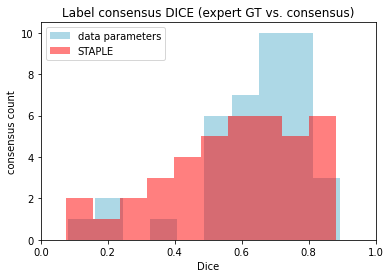

In [8]:
mean_dp_consensus = torch.cat(dp_consensus_dices)[:,1].mean()
print(f"DP consensus mean dice: {mean_dp_consensus.item():.3f}")
mean_staple = torch.cat(staple_consensus_dices)[:,1].mean()
print(f"STAPLE consensus mean dice: {mean_staple.item():.3f}")

# plt.hist(torch.cat()
plt.hist(torch.cat(dp_consensus_dices)[:,1].tolist(), color='lightblue', label="data parameters");
plt.hist(torch.cat(staple_consensus_dices)[:,1].tolist(),  alpha=0.5, color='red', label="STAPLE");
plt.title("Label consensus DICE (expert GT vs. consensus)")
plt.xlabel("Dice")
plt.xlim([0,1])
plt.ylabel("consensus count")
plt.legend()

In [ ]:
for f_id, dct in consensus_dicts.items():
    lbls = list(dct.values())

    for lbl in 
print(len(consensus_dicts))